# Image Segmentation on Forest Imagery (Deforested only)

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [ ]:
### import required packages
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [28]:
base_dir = 'data'
#base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [29]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [30]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.cast(alpha_channel > 0, tf.float32)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [31]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [32]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [33]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [34]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-26 18:54:20.390368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.403145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.403385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.408226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.410452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.414802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.417694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.418966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:54:20.425122: W tensorflow/core/lib/png/png_io.cc:89] PNG 

## Prepare for Modeling

In [35]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [36]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [37]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [38]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

## Default Architecture

In [ ]:
# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create submodel of MobileNetV2 

# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model
down_stack.trainable = False


In [41]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [43]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = tf.where(
        tf.equal(union, 0),  # Check where the union is zero
        1 - (tf.reduce_sum(y_pred, axis=[1, 2, 3]) / 244**2),  # Special case calculation
        intersection / union  # Regular IoU calculation
    )
    return iou

In [44]:
model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

### Functions to print results

In [45]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

In [21]:
# Iterate through the test dataset and display results
def display_results(model, test_dataset, threshold=0.5):
    for images, masks in test_dataset.take(1):
        preds = model.predict(images)
        predicted_masks = (preds>threshold).astype(np.uint8)
        for i in range(len(images)):
            display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())
            break

### Training with 1-Fold

In [50]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

train_accuracy = history.history['accuracy'][-1]      
train_iou = history.history['iou_metric'][-1]          
train_loss = history.history['loss'][-1]              

val_accuracy = history.history['val_accuracy'][-1]     
val_iou = history.history['val_iou_metric'][-1]       
val_loss = history.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Train IoU: {train_iou:.4f}")
print(f"Train loss: {train_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation IoU: {val_iou:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Epoch 1/30


2024-11-26 18:55:52.868901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.873551: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.881455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.884188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.888966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.889185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.894772: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.896322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:52.899444: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5977 - iou_metric: 0.1049 - loss: 0.6126

2024-11-26 18:55:58.719689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.719716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.719897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.723918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.726675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.726936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.732111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.733039: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:55:58.736870: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5993 - iou_metric: 0.1056 - loss: 0.6130 - val_accuracy: 0.7450 - val_iou_metric: 0.0564 - val_loss: 0.4820 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6756 - iou_metric: 0.1272 - loss: 0.5909 - val_accuracy: 0.8530 - val_iou_metric: 0.0834 - val_loss: 0.4697 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.7643 - iou_metric: 0.1837 - loss: 0.5203 - val_accuracy: 0.8990 - val_iou_metric: 0.1332 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7993 - iou_metric: 0.2091 - loss: 0.4576 - val_accuracy: 0.8987 - val_iou_metric: 0.1825 - val_loss: 0.4256 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8326 - iou_metric: 0.1823 - loss: 0.4070 - val_accuracy: 0.9056 - val_iou_metric: 0.1833 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 381m

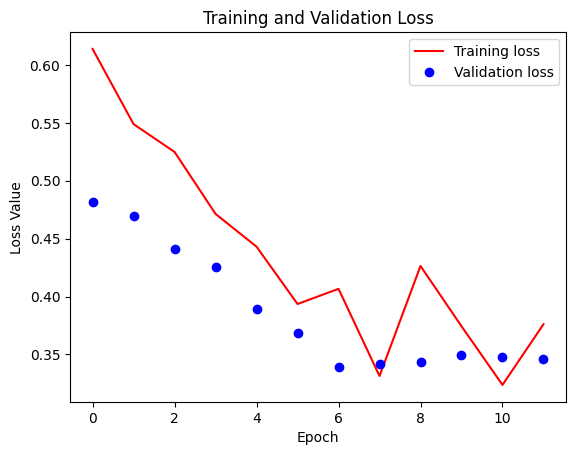

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

#### Predictions

In [54]:
predicted = model.predict(test_batches)

2024-11-26 18:59:28.906823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.906982: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.908627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.909677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.911445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.911601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.914333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.915424: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:28.917825: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [55]:
predicted_masks = (predicted>0.6).astype(int)

In [56]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - accuracy: 0.8326 - iou_metric: 0.4184 - loss: 0.4174
Test Loss: 0.4174056649208069
Test IOU: 0.4183652997016907
Test Accuracy: 83.26%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


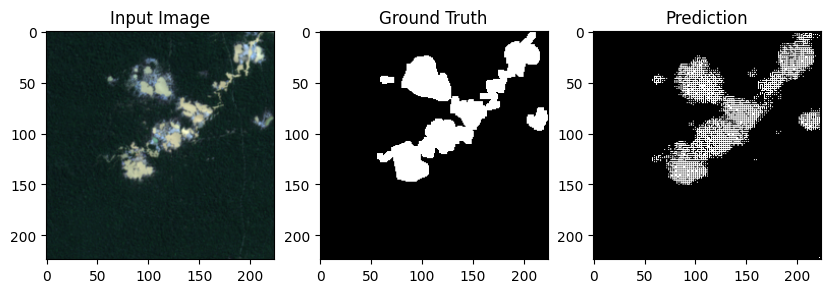

In [57]:
display_results(model, test_batches, threshold=0.6)

## Experimenting with K-Fold Cross Validation

In the following section, we tried 5- and 3-fold cross validation. We found that cross validation doesn't help improve the performance.

In [58]:
# Concatenate train_dataset and val_dataset to create a full training dataset for K-fold
train_dataset_full = train_dataset.concatenate(val_dataset)
EPOCHS = 30
BATCH_SIZE = 32
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

### 5-Fold Cross Validation

In [ ]:
k_folds = 5

k_fold_results = []
# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    train_dataset_full_copy = train_dataset_full
    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(Augment())
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule],
        verbose = 0
    )

    train_accuracy = history.history['accuracy'][-1]      
    train_iou = history.history['iou_metric'][-1]          
    train_loss = history.history['loss'][-1]              

    val_accuracy = history.history['val_accuracy'][-1]     
    val_iou = history.history['val_iou_metric'][-1]       
    val_loss = history.history['val_loss'][-1]            

    k_fold_results.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(k_fold_results[-1])

Training fold 1/5...


ValueError: Exception encountered when calling RandomFlip.call().

[1mExpected image tensor to have rank 3 (single image) or 4 (batch of images). Received: data.shape=(<tf.Tensor 'augment_11_1/sequential_30_1/random_flip_22_1/strided_slice_2:0' shape=() dtype=int32>, <tf.Tensor 'augment_11_1/sequential_30_1/random_flip_22_1/strided_slice_3:0' shape=() dtype=int32>, 224, 224, 3)[0m

Arguments received by RandomFlip.call():
  • data=tf.Tensor(shape=(None, None, 224, 224, 3), dtype=float32)
  • training=True

In [82]:
for i in k_fold_results:
    print(i)

{'fold': 1, 'train_accuracy': 0.8132493495941162, 'train_iou': 0.2053644210100174, 'train_loss': 0.36340948939323425, 'val_accuracy': 0.8013604879379272, 'val_iou': 0.28132426738739014, 'val_loss': 0.47227323055267334}
{'fold': 2, 'train_accuracy': 0.8151105046272278, 'train_iou': 0.18848519027233124, 'train_loss': 0.3424564301967621, 'val_accuracy': 0.7996399998664856, 'val_iou': 0.3965519964694977, 'val_loss': 0.4685865044593811}
{'fold': 3, 'train_accuracy': 0.8338062763214111, 'train_iou': 0.2126120626926422, 'train_loss': 0.321955144405365, 'val_accuracy': 0.7771989107131958, 'val_iou': 0.3005358874797821, 'val_loss': 0.484966903924942}
{'fold': 4, 'train_accuracy': 0.818006157875061, 'train_iou': 0.23307937383651733, 'train_loss': 0.37174713611602783, 'val_accuracy': 0.8101615905761719, 'val_iou': 0.3493568003177643, 'val_loss': 0.4500167667865753}
{'fold': 5, 'train_accuracy': 0.7837749123573303, 'train_iou': 0.014344076626002789, 'train_loss': 0.4259282052516937, 'val_accuracy'

####  Predictions

In [117]:
test_dataset = (test_dataset
                .batch(BATCH_SIZE)  # Ensure batching
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [83]:
predicted_k_fold = model.predict(test_batches)
predicted_masks_k_fold = (predicted_k_fold>0.4).astype(int)

2024-11-26 17:37:07.480779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.491485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.493383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.495783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.496429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.497764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.498328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.501958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:37:07.505257: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [84]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 0.7550 - iou_metric: 0.1548 - loss: 0.4942
Test Loss: 0.4942223131656647
Test IOU: 0.1548057496547699
Test Accuracy: 75.50%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


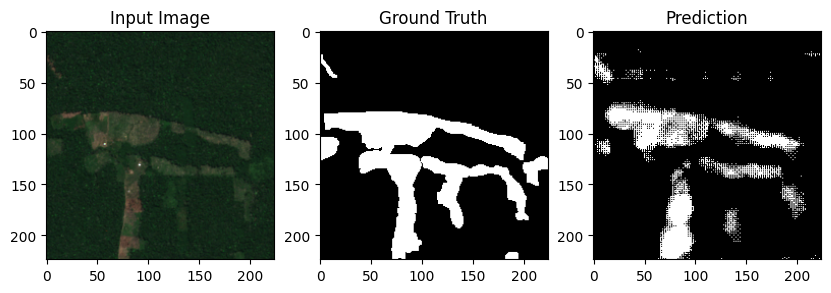

In [61]:
display_results(model, test_batches, threshold=0.6)

### 3-fold Cross Validation

In [ ]:
k_folds = 3

results_3_fold = []

# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    train_dataset_full_copy = train_dataset_full

    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model_3_fold = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model_3_fold.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history_3_fold = model_3_fold.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule],
        verbose = 0
    )

    train_accuracy = history_3_fold.history['accuracy'][-1]      
    train_iou = history_3_fold.history['iou_metric'][-1]          
    train_loss = history_3_fold.history['loss'][-1]              

    val_accuracy = history_3_fold.history['val_accuracy'][-1]     
    val_iou = history_3_fold.history['val_iou_metric'][-1]       
    val_loss = history_3_fold.history['val_loss'][-1]            

    results_3_fold.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(results_3_fold[-1])

Training fold 1/3...


2024-11-26 19:06:35.929667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.936990: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.939309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.940269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.942245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.949528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.951235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.956181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:35.956916: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 1, 'train_accuracy': 0.8156074285507202, 'train_iou': 0.0525326244533062, 'train_loss': 0.40538421273231506, 'val_accuracy': 0.7112502455711365, 'val_iou': 0.21674218773841858, 'val_loss': 0.5513876080513}
Training fold 2/3...


2024-11-26 19:06:59.077619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.081827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.081935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.087846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.093164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.096651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.100462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.113069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:06:59.116209: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 2, 'train_accuracy': 0.8339875340461731, 'train_iou': 0.06925249099731445, 'train_loss': 0.35750606656074524, 'val_accuracy': 0.7880125641822815, 'val_iou': 0.24526330828666687, 'val_loss': 0.4803895950317383}
Training fold 3/3...


2024-11-26 19:07:20.954535: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.954561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.959366: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.959471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.968164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.970035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.976087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.979130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:20.980446: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 3, 'train_accuracy': 0.8235774040222168, 'train_iou': 0.19655078649520874, 'train_loss': 0.4344642460346222, 'val_accuracy': 0.6018463373184204, 'val_iou': 0.2457411140203476, 'val_loss': 0.6783738136291504}


In [ ]:
for i in results_3_fold:
    print(i)

{'fold': 1, 'train_accuracy': 0.8156074285507202, 'train_iou': 0.0525326244533062, 'train_loss': 0.40538421273231506, 'val_accuracy': 0.7112502455711365, 'val_iou': 0.21674218773841858, 'val_loss': 0.5513876080513}
{'fold': 2, 'train_accuracy': 0.8339875340461731, 'train_iou': 0.06925249099731445, 'train_loss': 0.35750606656074524, 'val_accuracy': 0.7880125641822815, 'val_iou': 0.24526330828666687, 'val_loss': 0.4803895950317383}
{'fold': 3, 'train_accuracy': 0.8235774040222168, 'train_iou': 0.19655078649520874, 'train_loss': 0.4344642460346222, 'val_accuracy': 0.6018463373184204, 'val_iou': 0.2457411140203476, 'val_loss': 0.6783738136291504}


In [ ]:
test_loss, test_accuracy, test_iou = model_3_fold.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2024-11-26 19:07:45.385584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.393218: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.393970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.396470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.397716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.404201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.407297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.407646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 19:07:45.413432: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.6925 - iou_metric: 0.2898 - loss: 0.6235
Test Loss: 0.6235477924346924
Test IOU: 0.2898108661174774
Test Accuracy: 69.25%


## Experimenting with unfreezing layers

In the following section, we experimented with unfreezing 1 to 3 depest layers in our encoder to see if that would help improve our accuracy. 

### Final decision: unfreezing 1 layers

In [94]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [95]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [96]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4424 - iou_metric: 0.2102 - loss: 0.9010 - val_accuracy: 0.4654 - val_iou_metric: 0.1959 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4973 - iou_metric: 0.1639 - loss: 0.7128 - val_accuracy: 0.5270 - val_iou_metric: 0.1963 - val_loss: 0.8329 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - accuracy: 0.6171 - iou_metric: 0.1584 - loss: 0.6260 - val_accuracy: 0.6038 - val_iou_metric: 0.2087 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6331 - iou_metric: 0.1281 - loss: 0.5577 - val_accuracy: 0.6491 - val_iou_metric: 0.2300 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6912 - iou_metric: 0.1456 - loss: 0.5335 - val_accuracy: 0.6426 - val_iou_metric: 0.2569 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━

AttributeError: 'float' object has no attribute 'history'

In [101]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.8676
Train IoU: 0.4043
Train loss: 0.2718
Validation accuracy: 0.9012
Validation IoU: 0.5071
Validation loss: 0.2756


In [105]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

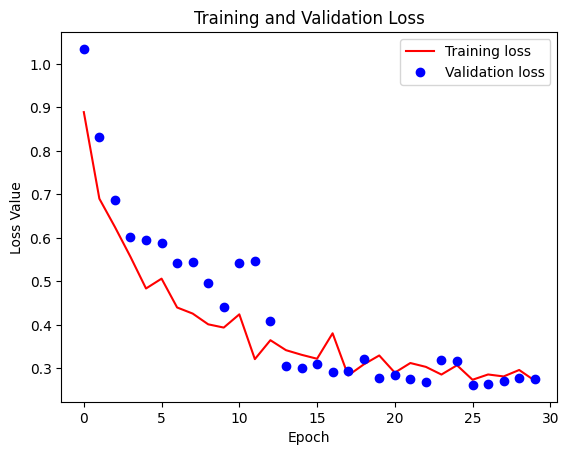

In [106]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [107]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


In [108]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 0.8600 - iou_metric: 0.4086 - loss: 0.3490
Test Loss: 0.34896257519721985
Test IOU: 0.40862837433815
Test Accuracy: 86.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


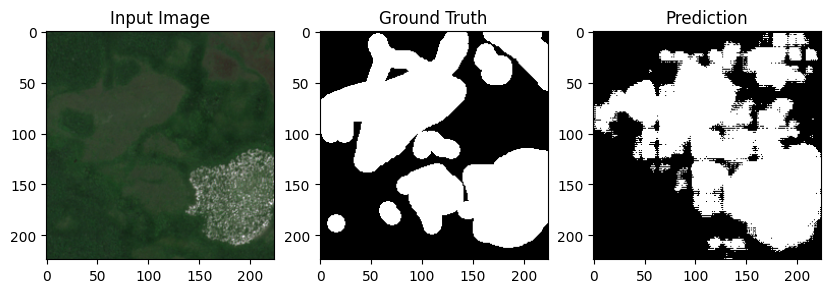

In [109]:
display_results(model_unfreeze, test_batches, threshold=0.5)

### Unfreezing 2 layers

In [110]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project', 'block_13_expand_relu']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [111]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [112]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7081 - iou_metric: 0.0952 - loss: 0.5933 - val_accuracy: 0.7835 - val_iou_metric: 0.1207 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7832 - iou_metric: 0.0350 - loss: 0.4938 - val_accuracy: 0.7754 - val_iou_metric: 0.0773 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.7494 - iou_metric: 0.0163 - loss: 0.4911 - val_accuracy: 0.7655 - val_iou_metric: 0.0411 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7489 - iou_metric: 0.0064 - loss: 0.4684 - val_accuracy: 0.7651 - val_iou_metric: 0.0374 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7253 - iou_metric: 0.0131 - loss: 0.4739 - val_accuracy: 0.7833 - val_iou_metric: 0.1010 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━

AttributeError: 'dict' object has no attribute 'history'

In [114]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.8586
Train IoU: 0.3487
Train loss: 0.2837
Validation accuracy: 0.8668
Validation IoU: 0.3863
Validation loss: 0.3096


In [118]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

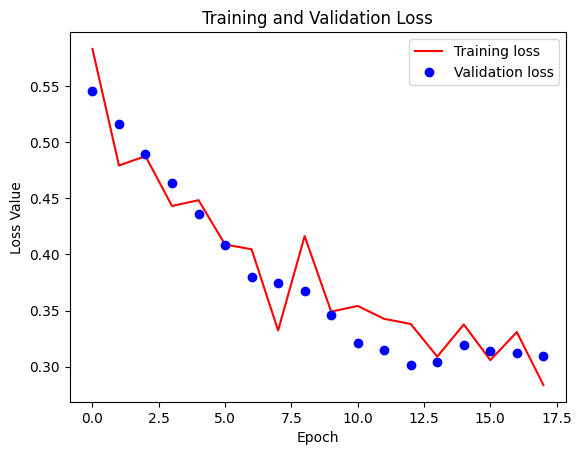

In [119]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [120]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


In [121]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8175 - iou_metric: 0.3207 - loss: 0.3905
Test Loss: 0.39050936698913574
Test IOU: 0.32071757316589355
Test Accuracy: 81.75%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


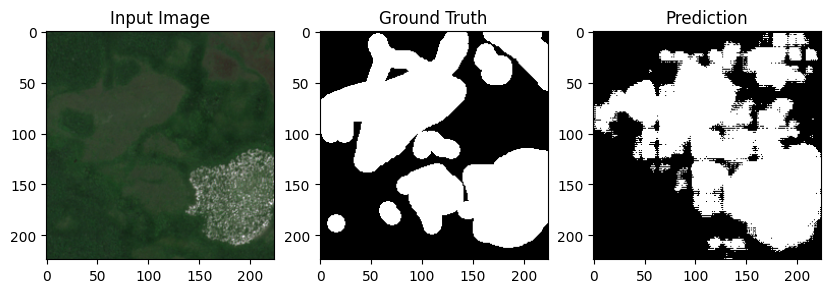

In [ ]:
display_results(model_unfreeze, test_batches, threshold=0.5)

### Unfreezing 3 layers

In [122]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [123]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [124]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [125]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2660 - iou_metric: 0.1951 - loss: 0.9586 - val_accuracy: 0.4473 - val_iou_metric: 0.2278 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4212 - iou_metric: 0.1213 - loss: 0.7395 - val_accuracy: 0.6878 - val_iou_metric: 0.2328 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.6110 - iou_metric: 0.1730 - loss: 0.6422 - val_accuracy: 0.7577 - val_iou_metric: 0.1841 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7143 - iou_metric: 0.1447 - loss: 0.5542 - val_accuracy: 0.7829 - val_iou_metric: 0.1450 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8138 - iou_metric: 0.0898 - loss: 0.4492 - val_accuracy: 0.7760 - val_iou_metric: 0.0942 - val_loss: 0.4880 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━

In [126]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.8557
Train IoU: 0.4301
Train loss: 0.2870
Validation accuracy: 0.8828
Validation IoU: 0.4322
Validation loss: 0.2907


In [127]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

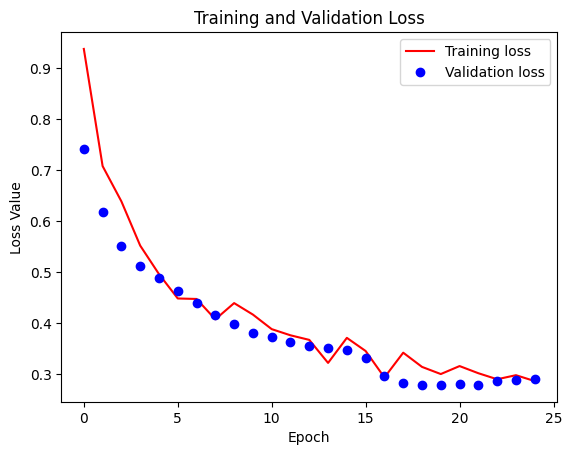

In [128]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [129]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


In [130]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8355 - iou_metric: 0.3579 - loss: 0.3750
Test Loss: 0.37504658102989197
Test IOU: 0.35789453983306885
Test Accuracy: 83.55%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


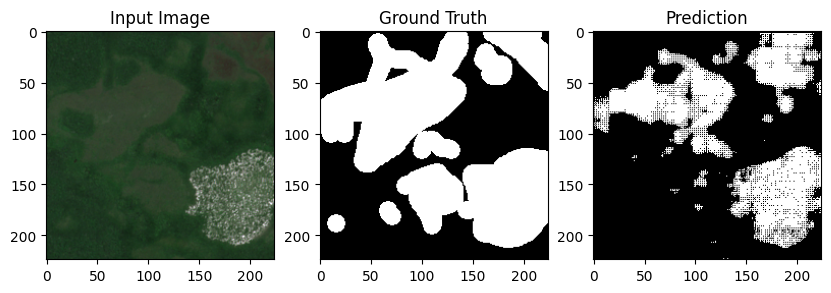

In [133]:
display_results(model_unfreeze, test_batches, threshold=0.4)